In [1]:
import sys
sys.path.append(r'C:\Users\dkq23\Documents\Python Scripts\crypto-ml-api')

import pandas as pd
import numpy as np

df = pd.read_csv('../data/bitcoin_features.csv')

from src.train_lstm import *

In [3]:
sequence_length=30
epochs=50
batch_size=32
learning_rate=0.001

In [4]:
print("Creating sequences...")
sequences, labels, feature_cols = create_sequences(df, sequence_length)
print(f"Created {len(sequences)} sequences with shape {sequences.shape}")

Creating sequences...
Created 307 sequences with shape (307, 30, 9)


In [6]:
# Ensure labels are integer type (CrossEntropy expects integer class labels)
labels = labels.astype(np.int64)

# Split data first (time-series split - no shuffle) to avoid data leakage when scaling
split_idx = int(len(sequences) * 0.8)
X_train = sequences[:split_idx]
y_train = labels[:split_idx]
X_val = sequences[split_idx:]
y_val = labels[split_idx:]


Scaling features (fit only on training set)...


In [10]:
print("\nScaling features (fit only on training set)...")
scaler = StandardScaler()
# Fit scaler on training set only
n_train, n_timesteps, n_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, n_features)
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_train = X_train_scaled.reshape(n_train, n_timesteps, n_features)

# Transform validation set using the same scaler
n_val = X_val.shape[0]
if n_val > 0:
    X_val_reshaped = X_val.reshape(-1, n_features)
    X_val_scaled = scaler.transform(X_val_reshaped)
    X_val = X_val_scaled.reshape(n_val, n_timesteps, n_features)

print(f"\nTrain size: {len(X_train)}, Validation size: {len(X_val)}")
# safe bincount prints
print(f"Class distribution - Train: {np.bincount(y_train) if len(y_train)>0 else 'empty'}, Val: {np.bincount(y_val) if len(y_val)>0 else 'empty'}")


Scaling features (fit only on training set)...

Train size: 245, Validation size: 62
Class distribution - Train: [123 122], Val: [30 32]


In [11]:
# Create datasets and dataloaders
train_dataset = CryptoDataset(X_train, y_train)
val_dataset = CryptoDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")


Using device: cuda


X_batch.shape = torch.Size([32, 30, 9]), y_batch.shape = torch.Size([32])
First labels: [0 0 1 0 1 0 0 1 0 0]


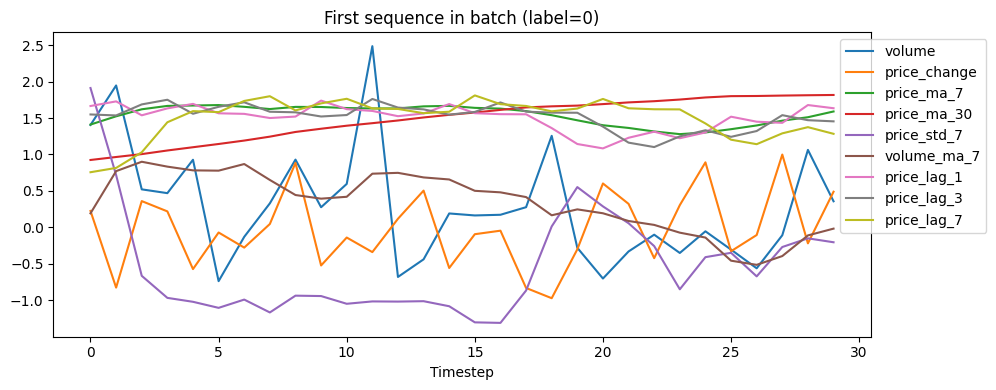

In [12]:
import matplotlib.pyplot as plt

# Peek one batch
batch = next(iter(train_loader))
X_batch, y_batch = batch  # expect (batch, seq_len, n_features), (batch,)

print(f"X_batch.shape = {X_batch.shape}, y_batch.shape = {y_batch.shape}")
# safe label preview
if hasattr(y_batch, "cpu"):
    print("First labels:", y_batch[:10].cpu().numpy())
else:
    print("First labels:", y_batch[:10])

# Select first sequence from batch and convert to numpy
seq = X_batch[0]
if hasattr(seq, "detach"):
    seq = seq.detach().cpu().numpy()

n_timesteps, n_features = seq.shape

plt.figure(figsize=(10, 4))
for i in range(n_features):
    label = feature_cols[i] if 'feature_cols' in globals() and i < len(feature_cols) else f"f{i}"
    plt.plot(range(n_timesteps), seq[:, i], label=label)
plt.xlabel("Timestep")
lbl = y_batch[0].item() if hasattr(y_batch[0], "item") else int(y_batch[0])
plt.title(f"First sequence in batch (label={lbl})")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

In [13]:
model = CryptoLSTM(
    input_size=n_features,
    hidden_size=64,
    num_layers=2,
    dropout=0.3
).to(device)

print(f"\nModel architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")


Model architecture:
CryptoLSTM(
  (lstm): LSTM(9, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

Total parameters: 54,626


In [14]:
# Capture only the nn.LSTM output via a forward hook (doesn't print the whole model)
loader = eval_loader if 'eval_loader' in globals() else val_loader
X_batch, y_batch = next(iter(loader))
X_batch = X_batch.to(device)

# find first LSTM module
lstm_mod = None
for m in model.modules():
    if isinstance(m, torch.nn.LSTM):
        lstm_mod = m
        break

if lstm_mod is None:
    print("No nn.LSTM module found in model.")
else:
    captured = {}
    def hook(module, inp, out):
        # out is (seq_output, (h_n, c_n))
        captured['out'] = out

    handle = lstm_mod.register_forward_hook(hook)
    model.eval()
    with torch.no_grad():
        _ = model(X_batch)   # run forward; hook will capture LSTM outputs
    handle.remove()

    if 'out' not in captured:
        print("Hook did not capture any output.")
    else:
        seq_out, (h_n, c_n) = captured['out']
        print("seq_out dtype/shape:", seq_out.dtype, seq_out.shape)
        # detect batch_first vs seq_first and show a small slice
        if seq_out.dim() == 3:
            batch_first = seq_out.shape[0] == X_batch.shape[0]
            if batch_first:
                print("sample seq_out [batch=0, timesteps 0:5, feats 0:5]:\n", seq_out[0, :5, :5].cpu().numpy())
            else:
                print("sample seq_out [timesteps 0:5, batch=0, feats 0:5]:\n", seq_out[:5, 0, :5].cpu().numpy())

        print("h_n shape:", h_n.shape, " sample (layers, batch=0, first 5 hidden):\n", h_n[:, 0, :5].cpu().numpy())
        print("c_n shape:", c_n.shape, " sample (layers, batch=0, first 5 hidden):\n", c_n[:, 0, :5].cpu().numpy())


seq_out dtype/shape: torch.float32 torch.Size([32, 30, 64])
sample seq_out [batch=0, timesteps 0:5, feats 0:5]:
 [[-0.05456695 -0.05775984 -0.01845496 -0.01635197 -0.01494469]
 [-0.07659367 -0.08742814 -0.0291871  -0.0202973  -0.01846067]
 [-0.08461205 -0.10434264 -0.03348112 -0.0239134  -0.01878122]
 [-0.08686686 -0.11417435 -0.03481266 -0.02901479 -0.01352676]
 [-0.0829235  -0.10612104 -0.04076791 -0.02304733 -0.01845083]]
h_n shape: torch.Size([2, 32, 64])  sample (layers, batch=0, first 5 hidden):
 [[ 0.06664616 -0.11803407  0.03626911  0.13053887 -0.21836656]
 [-0.09327224 -0.13320759 -0.03173019 -0.03774013 -0.00580631]]
c_n shape: torch.Size([2, 32, 64])  sample (layers, batch=0, first 5 hidden):
 [[ 0.12023426 -0.21251264  0.06924342  0.25797153 -0.39124608]
 [-0.19260752 -0.24060233 -0.06775664 -0.08013285 -0.01084305]]
